# Custom CNN for image classification
### Team: 0Idee (Bono Federico, Cecere Nicola, Zanutto Davide)

### Import libraries and set seed for reporducibility

In [1]:
import keras.models
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image
import splitfolders
from keras.preprocessing.image import ImageDataGenerator

tfk = tf.keras
tfkl = tf.keras.layers

2022-11-25 12:48:46.348548: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [3]:
# Set log levels

import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

### Data import

In [4]:
# Splitting the main dataset into train and val
dataset_dir = './dataset_split'

if not (os.path.exists(dataset_dir)):
    print('splitting')
    splitfolders.ratio('./training_data_final', output=dataset_dir, seed=seed, ratio=(0.8, 0.2))

# Setting dataset directories
training_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')

### Data augmentation

In [5]:
# Create an instance of ImageDataGenerator with Data Augmentation
aug_train_data_gen = ImageDataGenerator(
    rotation_range=20,
    brightness_range=(0.6, 1.4),
    zoom_range=0.6,
    fill_mode='reflect',
    rescale=1. / 255
)

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
aug_train_gen = aug_train_data_gen.flow_from_directory(
    directory=training_dir,
    target_size=(96, 96),
    color_mode='rgb',
    classes=None,
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=seed
)

Found 2829 images belonging to 8 classes.


In [7]:
valid_data_gen = ImageDataGenerator(rescale=1 / 255.)

valid_gen = valid_data_gen.flow_from_directory(
    directory=validation_dir,
    target_size=(96, 96),
    color_mode='rgb',
    classes=None,
    batch_size=32,
    shuffle=False,
    seed=seed
)

Found 713 images belonging to 8 classes.


## Model
### Parameters and configuration

In [6]:
input_shape = (96, 96, 3)
epochs = 200
labels = ['Species1', 'Species2', 'Species3', 'Species4', 'Species5', 'Species6', 'Species7', 'Species8']

# Weights are based on the number of samples and then fine-tuned on the train dataset
class_weights = {0: 2., 1: 1., 2: 1., 3: 1., 4: 1., 5: 2., 6: 1., 7: 1.}

### Model shape

In [8]:
def build_model(input_shape):
    # Input layer -------------------------------------------------------
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # First layer -------------------------------------------------------
    conv1 = tfkl.Conv2D(
        filters=32,
        kernel_size=3,
        padding='same',
        activation='relu',
        kernel_initializer=tfk.initializers.HeUniform(seed)
    )(input_layer)
    conv1 = tfkl.BatchNormalization()(conv1)
    pool1 = tfkl.MaxPooling2D()(conv1)

    # Second layer -------------------------------------------------------
    conv2 = tfkl.Conv2D(
        filters=64,
        kernel_size=3,
        padding='same',
        activation='relu',
        kernel_initializer=tfk.initializers.HeUniform(seed)
    )(pool1)
    conv2 = tfkl.BatchNormalization()(conv2)
    pool2 = tfkl.MaxPooling2D()(conv2)

    # Third layer -------------------------------------------------------
    conv3 = tfkl.Conv2D(
        filters=128,
        kernel_size=3,
        padding='same',
        activation='relu',
        kernel_initializer=tfk.initializers.HeUniform(seed)
    )(pool2)

    # Fourth layer -------------------------------------------------------
    conv4 = tfkl.Conv2D(
        filters=128,
        kernel_size=3,
        padding='same',
        activation='relu',
        kernel_initializer=tfk.initializers.HeUniform(seed)
    )(conv3)
    conv4 = tfkl.BatchNormalization()(conv4)
    pool3 = tfkl.MaxPooling2D()(conv4)

    # Fifth layer -------------------------------------------------------
    conv5 = tfkl.Conv2D(
        filters=256,
        kernel_size=3,
        padding='same',
        activation='relu',
        kernel_initializer=tfk.initializers.HeUniform(seed)
    )(pool3)
    conv5 = tfkl.BatchNormalization()(conv5)
    pool4 = tfkl.MaxPooling2D()(conv5)

    # Sixth layer -------------------------------------------------------
    conv6 = tfkl.Conv2D(
        filters=512,
        kernel_size=3,
        padding='same',
        activation='relu',
        kernel_initializer=tfk.initializers.HeUniform(seed)
    )(pool4)
    conv6 = tfkl.BatchNormalization()(conv6)
    pool5 = tfkl.MaxPooling2D()(conv6)

    # Flattening layer -------------------------------------------------------
    flattening_layer = tfkl.GlobalAvgPool2D(name='gap')(pool5)

    # Dense layers -------------------------------------------------------
    classifier_layer = tfkl.Dense(units=600, name='Classifier', kernel_initializer=tfk.initializers.GlorotUniform(seed),
                                  activation='relu')(flattening_layer)
    hidden_layer = tfkl.Dense(units=258, name='Hidden_layer', kernel_initializer=tfk.initializers.GlorotUniform(seed),
                              activation='relu')(classifier_layer)
    dropout = tfkl.Dropout(0.3, seed=seed)(hidden_layer)
    output_layer = tfkl.Dense(units=8, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed),
                              name='output_layer')(dropout)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(
        loss=tfk.losses.CategoricalCrossentropy(),
        optimizer=tfk.optimizers.Adam(),
        metrics=['accuracy', tfk.metrics.Precision(), tfk.metrics.Recall()]
    )

    # Return the model
    return model

In [9]:
# Build model (for data augmentation training)
model = build_model(input_shape)
model.summary()

Metal device set to: AMD Radeon Pro 5300M
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 96, 96, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 96, 96, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalizatio

### Fit callbacks

In [10]:
# Learning Rate Scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [11]:
from datetime import datetime

def create_folders_and_callbacks(model_name):
    exps_dir = os.path.join('data_augmentation_experiments')
    if not os.path.exists(exps_dir):
        os.makedirs(exps_dir)

    now = datetime.now().strftime('%b%d_%H-%M-%S')

    exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
    if not os.path.exists(exp_dir):
        os.makedirs(exp_dir)

    callbacks = []

    # Model checkpoint
    # ----------------
    ckpt_dir = os.path.join(exp_dir, 'ckpts')
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)

    ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'),
                                                       save_weights_only=True,  # True to save only weights
                                                       save_best_only=False)  # True to save only the best epoch
    callbacks.append(ckpt_callback)

    # Visualize Learning on Tensorboard
    # ---------------------------------
    tb_dir = os.path.join(exp_dir, 'tb_logs')
    if not os.path.exists(tb_dir):
        os.makedirs(tb_dir)

    # By default shows losses and metrics for both training and validation
    tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                                 profile_batch=0,
                                                 histogram_freq=1)
    callbacks.append(tb_callback)

    # Early Stopping
    # --------------
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    callbacks.append(es_callback)

    # Learning Rate Scheduler --------------------------------------------
    LRS_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
    callbacks.append(LRS_callback)

    return callbacks

### Training

In [13]:
# Create folders and callbacks and fit
aug_callbacks = create_folders_and_callbacks(model_name='CNN_Aug')

# Train the model
history = model.fit(
    x=aug_train_gen,
    epochs=epochs,
    validation_data=valid_gen,
    callbacks=aug_callbacks,
    batch_size=32,
    class_weight=class_weights
).history

Epoch 1/200
89/89 [==============================] - 20s 171ms/step - loss: 2.1622 - accuracy: 0.3121 - precision: 0.4146 - recall: 0.1124 - val_loss: 3.0660 - val_accuracy: 0.1459 - val_precision: 0.1548 - val_recall: 0.1403 - lr: 0.0010
Epoch 2/200
13/89 [===>..........................] - ETA: 11s - loss: 1.8570 - accuracy: 0.4135 - precision: 0.5000 - recall: 0.1635

KeyboardInterrupt: 

In [14]:
# Save best epoch model
model.save("data_augmentation_experiments/CNN_Aug_Best")

## Results
### Confusion matrix, Accuracy, Precision and Recall

In [15]:
def get_next_batch(generator):
    return next(generator)

batch = get_next_batch(valid_gen)
true_label = batch[1]
pred_label = model.predict(batch[0])
for i in range(0, 500):
    batch = get_next_batch(valid_gen)
    true_label = np.concatenate((true_label, batch[1]), axis=0)
    pred_label = np.concatenate((pred_label, model.predict(batch[0])), axis=0)

1/1 [==============================] - 0s 46ms/step


KeyboardInterrupt: 

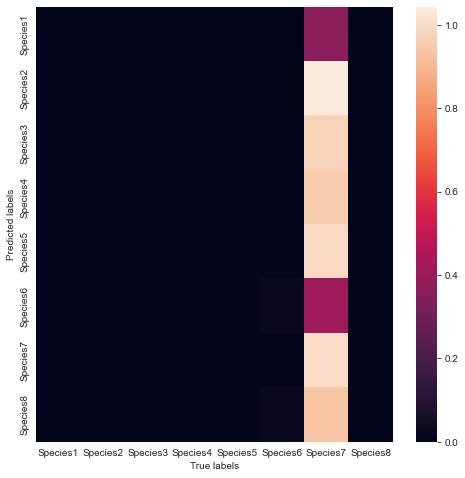

In [16]:
#confusion matrix
cm = confusion_matrix(np.argmax(true_label, axis=-1), np.argmax(pred_label, axis=-1))
# Plot the confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm / sum(true_label), xticklabels=labels, yticklabels=labels)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [17]:
ALPHA = 1

plt.figure(figsize=(20,10))

plt.plot(history['accuracy'], label='Accuracy [train]', alpha=ALPHA, color='#2B2118')
plt.plot(history['val_accuracy'], label='Accuracy [val]', alpha=ALPHA, color='#836449')

plt.plot(history['precision'], label='Precision [train]', alpha=ALPHA, color='#F04019')
plt.plot(history['val_precision'], label='Precision [val]', alpha=ALPHA, color='#F07518')

plt.plot(history['recall'], label='Recall [train]', alpha=ALPHA, color='#D2BB60')
plt.plot(history['val_recall'], label='Recall [val]', alpha=ALPHA, color='#B3D160')

plt.ylim(0.1, 1)
plt.title('Results')
plt.legend(loc='lower right')
plt.grid(alpha=.3)
plt.show()

NameError: name 'history' is not defined

<Figure size 1440x720 with 0 Axes>

In [ ]:
# Accuracy Graph
plt.figure(figsize=(20,10))

plt.plot(history['accuracy'], label='Accuracy [train]', alpha=ALPHA, color='#2B2118')
plt.plot(history['val_accuracy'], label='Accuracy [val]', alpha=ALPHA, color='#836449')

plt.ylim(.1, 1)
plt.title('Accuracy')
plt.legend(loc='lower right')
plt.grid(alpha=.3)
plt.show()


In [ ]:
# Precision Graph
plt.figure(figsize=(20,10))

plt.plot(history['precision'], label='Precision [train]', alpha=ALPHA, color='#F04019')
plt.plot(history['val_precision'], label='Precision [val]', alpha=ALPHA, color='#F07518')

plt.ylim(.1, 1)
plt.title('Precision')
plt.legend(loc='lower right')
plt.grid(alpha=.3)
plt.show()

In [ ]:

# Recall Graph
plt.figure(figsize=(20,10))

plt.plot(history['recall'], label='Recall Train', alpha=ALPHA, color='#303F9F')
plt.plot(history['val_recall'], label='Recall Val', alpha=ALPHA, color='#1976D2')

plt.ylim(.5, 1)
plt.title('Recall')
plt.legend(loc='lower right')
plt.grid(alpha=.3)
plt.show()


In [ ]:
# Loss Graph
plt.figure(figsize=(15,10))

plt.plot(history['recall'], label='Recall [train]', alpha=ALPHA, color='#D2BB60')
plt.plot(history['val_recall'], label='Recall [val]', alpha=ALPHA, color='#B3D160')

plt.ylim(0, 1)
plt.title('Loss')
plt.legend(loc='upper right')
plt.grid(alpha=.3)
plt.show()